# Decision Trees

This exercise is part of the Dell EMC Big Data and Analytics Associate Certificate

### 1. Reading Data

In [7]:
car_data <- read.table("datasets/car_evaluation.csv", header=TRUE, sep=",")

In [35]:
# Transform Label Column to be "Acceptable or NotAcceptable
accept_or_not <- function(acceptable){
    if(acceptable == "unacc"){
        return("unacc")
    }else if(acceptable != "unacc"){
        return("acc")
    }
}

car_data$car_acceptability <- sapply(car_data$car_acceptability, accept_or_not)


summary(car_data)

   buying      maint       doors     persons     lug_boot    safety   
 high :432   high :432   2    :432   2   :576   big  :576   high:576  
 low  :432   low  :432   3    :432   4   :576   med  :576   low :576  
 med  :432   med  :432   4    :432   more:576   small:576   med :576  
 vhigh:432   vhigh:432   5more:432                                    
 car_acceptability 
 Length:1728       
 Class :character  
 Mode  :character  
                   

In [36]:
car_data_mod <- car_data

In [37]:
car_data_mod$buying <- factor(car_data_mod$buying, levels = c("low", "med", "high", "vhigh"), ordered=TRUE)
car_data_mod$maint <- factor(car_data_mod$maint, levels = c("low", "med", "high", "vhigh"), ordered=TRUE)
car_data_mod$doors <- factor(car_data_mod$doors, levels = c("2", "3", "4", "5more"), ordered=TRUE)
car_data_mod$persons <- factor(car_data_mod$persons, levels = c("2", "4", "more"), ordered=TRUE)
car_data_mod$lug_boot <- factor(car_data_mod$lug_boot, levels = c("small", "med", "big"), ordered=TRUE)
car_data_mod$safety <- factor(car_data_mod$safety, levels = c("low", "med", "high"), ordered=TRUE)
car_data_mod$car_acceptability <- factor(car_data_mod$car_acceptability, levels = c("acc", "unacc"), ordered=TRUE)

### 2. Split Data into training and test set

In [66]:
library(caTools)
set.seed(4000) # So we'll get same results running the model many times
rows <- sample.split(car_data_mod$car_acceptability, SplitRatio=0.8)
car_data_train <-subset(car_data_mod, rows == TRUE)
car_data_test <- subset(car_data_mod, rows == FALSE)
head(car_data_mod)

,buying,maint,doors,persons,lug_boot,safety,car_acceptability
,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>
1,vhigh,vhigh,2,2,small,low,unacc
2,vhigh,vhigh,2,2,small,med,unacc
3,vhigh,vhigh,2,2,small,high,unacc
4,vhigh,vhigh,2,2,med,low,unacc
5,vhigh,vhigh,2,2,med,med,unacc
6,vhigh,vhigh,2,2,med,high,unacc


### 3. Build the Decision Tree

In [67]:
library(rpart)

# Set minimum node size to split to 140 to avoid overfitting
model <- rpart(car_acceptability ~ buying + maint + doors + persons + lug_boot + safety, data=car_data_mod,
            control=rpart.control(minsplit=140), parms=list(split='information'))

summary(model)
# SPLIT 6 bring best results (lowest errors)
# Variable importance is also printed

Call:
rpart(formula = car_acceptability ~ buying + maint + doors + 
    persons + lug_boot + safety, data = car_data_mod, parms = list(split = "information"), 
    control = rpart.control(minsplit = 140))
  n= 1728 

          CP nsplit rel error    xerror       xstd
1 0.25868726      0 1.0000000 1.0000000 0.03676681
2 0.09266409      2 0.4826255 0.4826255 0.02822966
3 0.05019305      4 0.2972973 0.2972973 0.02286447
4 0.01158301      5 0.2471042 0.2895753 0.02259423
5 0.01000000      6 0.2355212 0.2934363 0.02272994

Variable importance
  safety  persons    maint   buying lug_boot 
      40       34       13       10        3 

Node number 1: 1728 observations,    complexity param=0.2586873
  predicted class=unacc  expected loss=0.2997685  P(node) =1
    class counts:   518  1210
   probabilities: 0.300 0.700 
  left son=2 (1152 obs) right son=3 (576 obs)
  Primary splits:
      persons  splits as  RLL,  improve=262.57900, (0 missing)
      safety   splits as  RLL,  improve=262.57900,

### Plot the Decision Tree

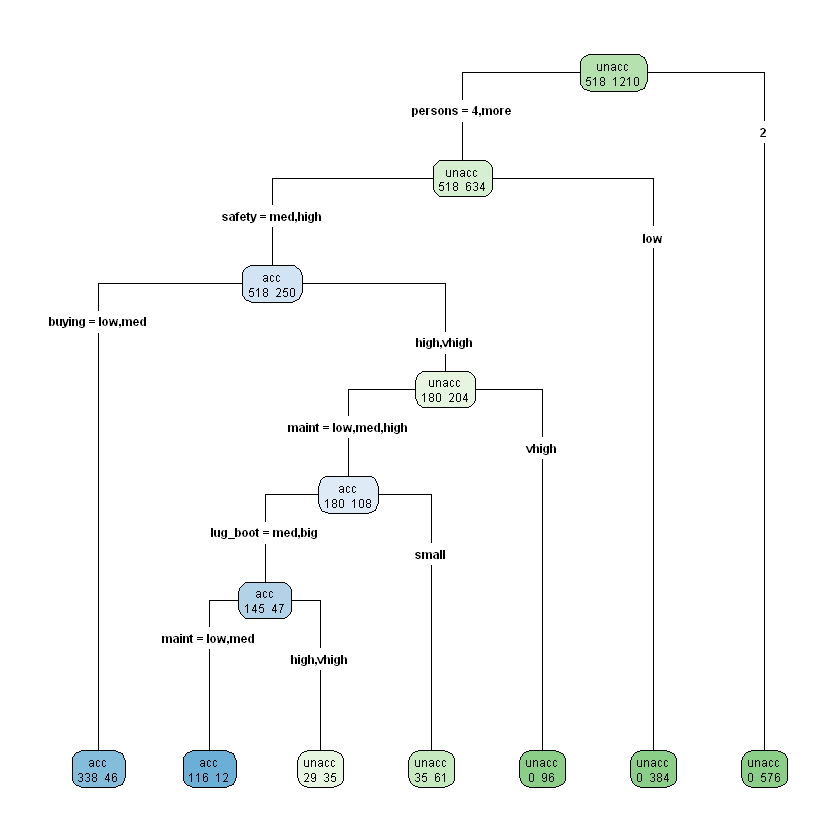

In [68]:
#?rpart.plot
#!install.packages("rpart.plot")
library("rpart.plot")
rpart.plot(model, type=4, extra=1)
# cars with 2 doors are unacceptable (in terms of a good decision)

In [69]:
model$variable.importance

safety   persons     maint    buying  lug_boot 
308.07725 262.57901  97.83931  78.42036  20.69749

### Do Predictions - Apply Fitted Model to the Test Dataset

In [70]:
pred_car_acc <- predict(model, newdata = car_data_test, type="class")

### Build Confusion Matrix

In [73]:
# !install.packages("gmodels")
library(gmodels)

CrossTable(pred_car_acc,
          car_data_test$car_acceptability,
          prop.chistq = FALSE, # as before
          prop.t = FALSE, # eliminate cell proportions
          dnn = c("predicted", "actual"))

# 5% of False Positives
# 6.7% of False Negatives

Warning message:
"package 'gmodels' was built under R version 3.6.3"



 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  346 

 
             | actual 
   predicted |       acc |     unacc | Row Total | 
-------------|-----------|-----------|-----------|
         acc |        97 |        12 |       109 | 
             |   125.947 |    54.126 |           | 
             |     0.890 |     0.110 |     0.315 | 
             |     0.933 |     0.050 |           | 
-------------|-----------|-----------|-----------|
       unacc |         7 |       230 |       237 | 
             |    57.925 |    24.893 |           | 
             |     0.030 |     0.970 |     0.685 | 
             |     0.067 |     0.950 |           | 
-------------|-----------|-----------|-----------|
Column Total |       104 |       242 |       346 | 
             |     0.301 |     0.699 |           | 
-------------|---------